# Machine Learning Models Implementation

This notebook implements several ML models based on the EDA and PCA results. The top 14 features identified after PCA are used for modeling. The workflow includes:

- Data loading and preprocessing (scaling, one-hot encoding)
- Train/validation/test split (80/10/10)
- Model training and hyperparameter tuning using Optuna
- Models: Logistic Regression (Ridge & Lasso), Naive Bayes, Random Forest, SVM, Decision Tree

**Top 14 Features:**
1. RiskScore
2. MonthlyCharges
3. AvgChargesPerMonth
4. ContractRisk
5. Contract
6. TotalServices
7. TotalCharges
8. EstimatedCLV
9. HasFamily
10. tenure
11. Partner
12. HighValueCustomer
13. PaymentRisk
14. Dependents

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import optuna

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Set constant seed for reproducibility
SEED = 42
np.random.seed(SEED)
# Remove optuna.seed(SEED) as it does not exist

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pip install optuna


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load dataset and select top 14 features
features = [
    'RiskScore', 'MonthlyCharges', 'AvgChargesPerMonth', 'ContractRisk', 'Contract',
    'TotalServices', 'TotalCharges', 'EstimatedCLV', 'HasFamily', 'tenure',
    'Partner', 'HighValueCustomer', 'PaymentRisk', 'Dependents'
]
df = pd.read_csv('final_telco_engineered.csv')
X = df[features]
# Assuming target column is 'Churn' (update if different)
y = df['Churn']

In [4]:
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['Contract', 'HasFamily', 'Partner', 'HighValueCustomer', 'Dependents']
numerical_cols = [col for col in features if col not in categorical_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [5]:
# Train/validation/test split (80/10/10)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=SEED, stratify=y_temp)
# 0.1111 * 0.90 ≈ 0.10

In [6]:
# Fit preprocessor and transform data
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

## Hyperparameter Tuning and Model Training

The following cells use Optuna for hyperparameter optimization for each model. The best model from validation is then evaluated on the test set.

In [7]:
# Metrics helper: accuracy, precision, recall, specificity, F1
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_metrics(y_true, y_pred, pos_label):
    labels = np.unique(y_true)
    if pos_label not in labels:
        raise ValueError("pos_label not found in y_true labels.")
    # Determine negative label (binary case expected)
    neg_candidates = [l for l in labels if l != pos_label]
    specificity = float('nan')
    if len(neg_candidates) == 1:
        neg_label = neg_candidates[0]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[neg_label, pos_label]).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=pos_label, zero_division=0)
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | Specificity: {specificity:.4f} | F1: {f1:.4f}")

Trial 0: penalty=l2, C=0.8471801418819978, score=0.7546
Trial 1: penalty=l1, C=0.004207053950287938, score=0.6908
Trial 2: penalty=l2, C=0.2537815508265665, score=0.7546
Trial 3: penalty=l1, C=7.579479953348009, score=0.7546
Trial 4: penalty=l1, C=0.005337032762603957, score=0.7021
Trial 5: penalty=l2, C=0.12561043700013558, score=0.7560
Trial 6: penalty=l1, C=0.2801635158716261, score=0.7504
Trial 7: penalty=l2, C=0.029204338471814112, score=0.7546
Trial 8: penalty=l2, C=0.006290644294586149, score=0.7489
Trial 9: penalty=l2, C=0.0015339162591163618, score=0.7390
Trial 10: penalty=l2, C=0.036623125456062326, score=0.7546
Trial 11: penalty=l2, C=1.460193429915262, score=0.7546
Trial 12: penalty=l2, C=1.1879278136421232, score=0.7546
Trial 13: penalty=l2, C=1.065615207940807, score=0.7532
Trial 14: penalty=l2, C=0.12775215110810637, score=0.7560
Trial 15: penalty=l2, C=0.057517078442021106, score=0.7546
Trial 16: penalty=l2, C=0.18265798300334693, score=0.7574
Trial 17: penalty=l2, C=0.

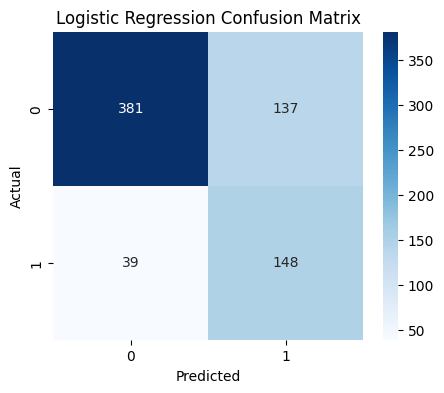

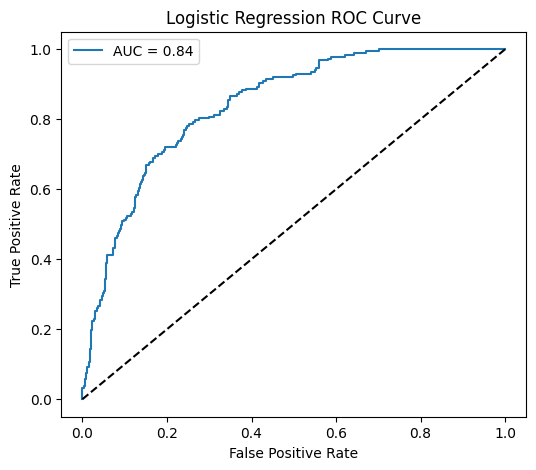

In [ ]:
# Logistic Regression (Ridge & Lasso) with Optuna and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

def objective_logreg(trial):
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 1e-3, 10.0, log=True)
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    clf = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000, random_state=SEED, class_weight=class_weight_dict)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = accuracy_score(y_val, y_pred)
    print(f'Trial {trial.number}: penalty={penalty}, C={C}, score={score:.4f}')
    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_logreg = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_logreg.optimize(objective_logreg, n_trials=50)

print(f'\nBest Logistic Regression Hyperparameters: {study_logreg.best_params}')
print(f'Best Validation Accuracy: {study_logreg.best_value:.4f}\n')

best_params_logreg = study_logreg.best_params
best_logreg = LogisticRegression(**best_params_logreg, solver='liblinear' if best_params_logreg['penalty']=='l1' else 'lbfgs', max_iter=1000, random_state=SEED, class_weight=class_weight_dict)
best_logreg.fit(X_train_proc, y_train)
y_test_pred_logreg = best_logreg.predict(X_test_proc)
y_test_proba_logreg = best_logreg.predict_proba(X_test_proc)[:, 1]

print('Logistic Regression Test Metrics:')
print_metrics(y_test, y_test_pred_logreg, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_logreg)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_logreg, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_logreg)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

Trial 0: var_smoothing=3.148911647956852e-10, score=0.7078
Trial 1: var_smoothing=6.351221010640693e-08, score=0.7078
Trial 2: var_smoothing=8.47180141881997e-09, score=0.7078
Trial 3: var_smoothing=2.481040974867806e-09, score=0.7078
Trial 4: var_smoothing=4.2079886696066266e-11, score=0.7078
Trial 5: var_smoothing=4.2070539502879275e-11, score=0.7078
Trial 6: var_smoothing=1.707396743152808e-11, score=0.7078
Trial 7: var_smoothing=2.9154431891537547e-08, score=0.7078
Trial 8: var_smoothing=2.5378155082656586e-09, score=0.7078
Trial 9: var_smoothing=6.796578090758142e-09, score=0.7078
Trial 10: var_smoothing=3.147070849889824e-10, score=0.7078
Trial 11: var_smoothing=3.6313970346434915e-10, score=0.7078
Trial 12: var_smoothing=7.553503645583179e-08, score=0.7078
Trial 13: var_smoothing=2.4400771927662207e-10, score=0.7078
Trial 14: var_smoothing=9.714866589957516e-10, score=0.7078
Trial 15: var_smoothing=2.7531913049290154e-08, score=0.7078
Trial 16: var_smoothing=1.0514141925502058e-

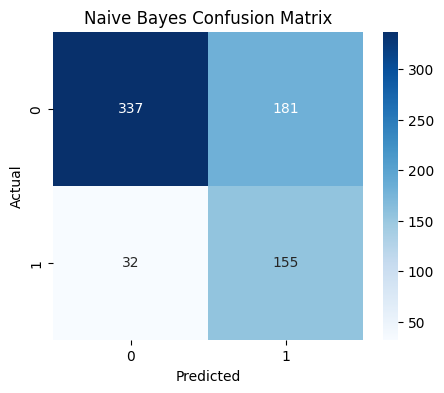

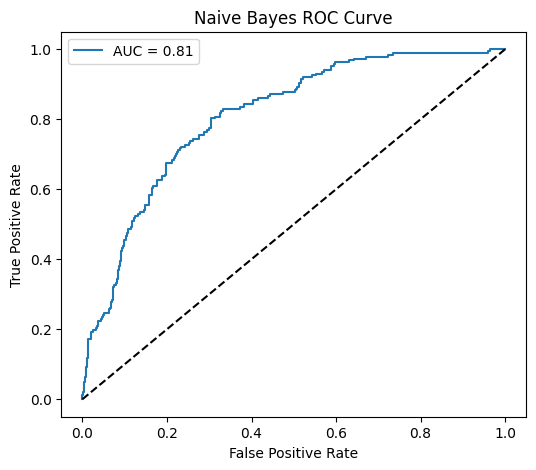

In [ ]:
# Naive Bayes with Optuna (GaussianNB) and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def objective_nb(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-7, log=True)
    clf = GaussianNB(var_smoothing=var_smoothing)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = accuracy_score(y_val, y_pred)
    print(f'Trial {trial.number}: var_smoothing={var_smoothing}, score={score:.4f}')
    return score

study_nb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_nb.optimize(objective_nb, n_trials=50)

print(f'\nBest Naive Bayes Hyperparameters: {study_nb.best_params}')
print(f'Best Validation Accuracy: {study_nb.best_value:.4f}\n')

best_params_nb = study_nb.best_params
best_nb = GaussianNB(**best_params_nb)
best_nb.fit(X_train_proc, y_train)
y_test_pred_nb = best_nb.predict(X_test_proc)
y_test_proba_nb = best_nb.predict_proba(X_test_proc)[:, 1]

print('Naive Bayes Test Metrics:')
print_metrics(y_test, y_test_pred_nb, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_nb, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_nb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend()
plt.show()

Trial 0: n_estimators=144, max_depth=20, min_samples_split=8, min_samples_leaf=6, score=0.7858
Trial 1: n_estimators=89, max_depth=4, min_samples_split=2, min_samples_leaf=9, score=0.7461
Trial 2: n_estimators=200, max_depth=15, min_samples_split=2, min_samples_leaf=10, score=0.7674
Trial 3: n_estimators=258, max_depth=6, min_samples_split=3, min_samples_leaf=2, score=0.7574
Trial 4: n_estimators=126, max_depth=11, min_samples_split=5, min_samples_leaf=3, score=0.7787
Trial 5: n_estimators=203, max_depth=4, min_samples_split=4, min_samples_leaf=4, score=0.7489
Trial 6: n_estimators=164, max_depth=16, min_samples_split=3, min_samples_leaf=6, score=0.7844
Trial 7: n_estimators=198, max_depth=2, min_samples_split=7, min_samples_leaf=2, score=0.7277
Trial 8: n_estimators=66, max_depth=20, min_samples_split=10, min_samples_leaf=9, score=0.7745
Trial 9: n_estimators=126, max_depth=3, min_samples_split=8, min_samples_leaf=5, score=0.7362
Trial 10: n_estimators=287, max_depth=19, min_samples_s

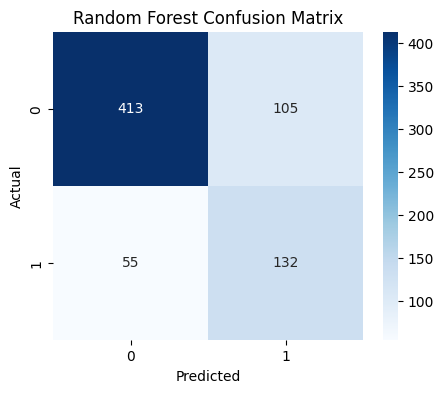

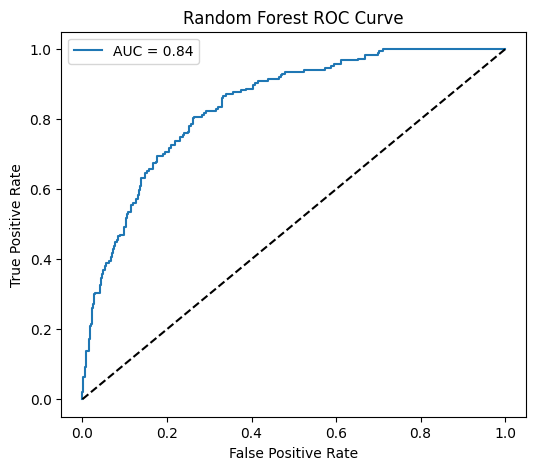

In [ ]:
# Random Forest with Optuna and single validation split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
        class_weight=class_weight_dict
    )
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = accuracy_score(y_val, y_pred)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, score={score:.4f}')
    return score

study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_rf.optimize(objective_rf, n_trials=50)

print(f'\nBest Random Forest Hyperparameters: {study_rf.best_params}')
print(f'Best Validation Accuracy: {study_rf.best_value:.4f}\n')

best_params_rf = study_rf.best_params
best_rf = RandomForestClassifier(**best_params_rf, random_state=SEED, class_weight=class_weight_dict)
best_rf.fit(X_train_proc, y_train)
y_test_pred_rf = best_rf.predict(X_test_proc)
y_test_proba_rf = best_rf.predict_proba(X_test_proc)[:, 1]

print('Random Forest Test Metrics:')
print_metrics(y_test, y_test_pred_rf, pos_label='Yes')

print('Random Forest Test Accuracy:', accuracy_score(y_test, y_test_pred_rf))
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_rf, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend()
plt.show()

/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 0: C=0.0746, kernel=linear, gamma=0.0003, score=0.6695


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 1 timed out.


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 1: C=0.0060, kernel=rbf, gamma=0.0133, score=0.6879
Trial 2: C=0.0013, kernel=linear, gamma=0.0004, score=0.6865


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 3 timed out.


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 3: C=0.0083, kernel=rbf, gamma=0.0007, score=0.7348
Trial 4: C=1.1462, kernel=poly, gamma=0.0023, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 5: C=8.4310, kernel=poly, gamma=0.0001, score=0.2652


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 6: C=1.0907, kernel=poly, gamma=0.0789, score=0.7418


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 7: C=11.0151, kernel=poly, gamma=0.0021, score=0.5319


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 8: C=0.0041, kernel=poly, gamma=0.0006, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 9: C=2.0541, kernel=poly, gamma=0.0004, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 10 timed out.


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 11: C=0.4160, kernel=poly, gamma=0.0115, score=0.4511


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 12: C=0.1935, kernel=poly, gamma=0.0693, score=0.7064


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 13: C=1.0615, kernel=poly, gamma=0.0051, score=0.3135


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 14: C=0.0692, kernel=poly, gamma=0.0255, score=0.5177


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 15: C=5.0402, kernel=rbf, gamma=0.0022, score=0.6695


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 16: C=27.0093, kernel=poly, gamma=0.0055, score=0.5972


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 17: C=1.2346, kernel=poly, gamma=0.0317, score=0.6936


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 18: C=0.0421, kernel=rbf, gamma=0.0012, score=0.6667


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 19: C=0.3100, kernel=linear, gamma=0.0042, score=0.6695


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 20: C=2.8616, kernel=poly, gamma=0.0090, score=0.5518


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 21: C=0.0161, kernel=poly, gamma=0.0009, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 22: C=0.0012, kernel=poly, gamma=0.0017, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 23: C=0.7979, kernel=poly, gamma=0.0006, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 24: C=0.1280, kernel=poly, gamma=0.0002, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 25: C=0.0181, kernel=poly, gamma=0.0011, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 26: C=0.4595, kernel=poly, gamma=0.0027, score=0.7348


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 27: C=18.3500, kernel=poly, gamma=0.0304, score=0.7433


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 28 timed out.


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 29: C=89.2663, kernel=rbf, gamma=0.0179, score=0.7560


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 30: C=91.1898, kernel=rbf, gamma=0.0202, score=0.7560


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 31: C=92.3764, kernel=rbf, gamma=0.0173, score=0.7560


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 32: C=88.9372, kernel=rbf, gamma=0.0190, score=0.7546


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 33: C=79.2757, kernel=rbf, gamma=0.0184, score=0.7560


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 34: C=45.6750, kernel=rbf, gamma=0.0163, score=0.7504


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 35: C=82.0363, kernel=rbf, gamma=0.0076, score=0.7390


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 36: C=41.5669, kernel=rbf, gamma=0.0435, score=0.7461


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 28: C=23.4267, kernel=linear, gamma=0.0407, score=0.6695
Trial 37: C=13.3322, kernel=rbf, gamma=0.0122, score=0.7291


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 38: C=5.0601, kernel=rbf, gamma=0.0194, score=0.7319


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 39: C=34.2304, kernel=rbf, gamma=0.0430, score=0.7475


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 40: C=7.3664, kernel=rbf, gamma=0.0079, score=0.7064


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 41: C=66.8835, kernel=rbf, gamma=0.0226, score=0.7574


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 42: C=90.1551, kernel=rbf, gamma=0.0613, score=0.7574


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 43: C=44.4085, kernel=rbf, gamma=0.0493, score=0.7461


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 44: C=92.0069, kernel=rbf, gamma=0.0627, score=0.7589


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 45: C=19.7757, kernel=rbf, gamma=0.0601, score=0.7447


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 46: C=58.8480, kernel=rbf, gamma=0.0993, score=0.7560


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 47: C=12.9823, kernel=rbf, gamma=0.0279, score=0.7518


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 48: C=31.1739, kernel=rbf, gamma=0.0568, score=0.7475


/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
/var/folders/7g/xvz8wfd9477_ywln21gwjvdr0000gn/T/ipykernel_4451/3801870198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)


Trial 49: C=56.2651, kernel=rbf, gamma=0.0952, score=0.7546
SVM Test Metrics:
Accuracy: 0.7461 | Precision: 0.5135 | Recall: 0.8128 | Specificity: 0.7220 | F1: 0.6294


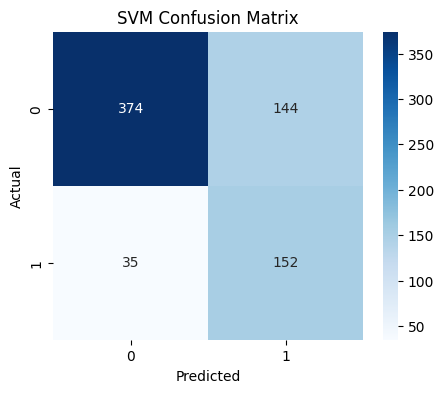

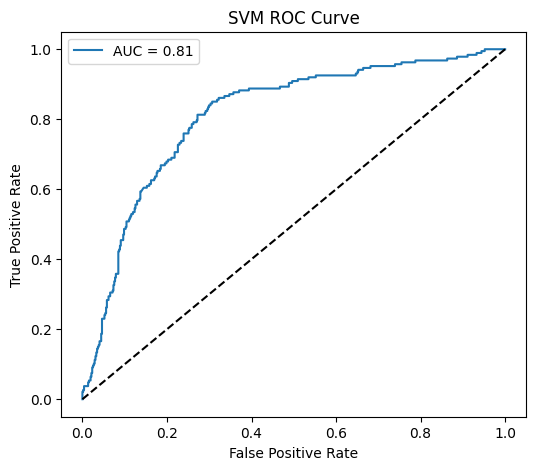

Trial 10: C=59.5769, kernel=linear, gamma=0.0810, score=0.6695


In [ ]:
# SVM with Optuna and single validation split, with timeout for each trial
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import optuna
import threading
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Timeout wrapper for objective function
class TrialTimeout(Exception):
    pass

def run_with_timeout(func, args=(), kwargs=None, timeout=60):
    result = {}
    def target():
        try:
            result['value'] = func(*args, **(kwargs or {}))
        except Exception as e:
            result['error'] = e
    thread = threading.Thread(target=target)
    thread.start()
    thread.join(timeout)
    if thread.is_alive():
        raise TrialTimeout('Trial exceeded timeout')
    if 'error' in result:
        raise result['error']
    return result.get('value')

def objective_svm(trial):
    def inner_objective():
        C = trial.suggest_loguniform('C', 1e-3, 1e2)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
        clf = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, random_state=SEED, class_weight=class_weight_dict)
        clf.fit(X_train_proc, y_train)
        y_pred = clf.predict(X_val_proc)
        score = accuracy_score(y_val, y_pred)
        print(f'Trial {trial.number}: C={C:.4f}, kernel={kernel}, gamma={gamma:.4f}, score={score:.4f}')
        return score
    try:
        return run_with_timeout(inner_objective, timeout=30)  # 30 seconds per trial
    except TrialTimeout:
        print(f'Trial {trial.number} timed out.')
        return 0.0  # Return poor score if timeout

study_svm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_svm.optimize(objective_svm, n_trials=50)

print(f'\nBest SVM Hyperparameters: {study_svm.best_params}')
print(f'Best Validation Accuracy: {study_svm.best_value:.4f}\n')

best_params_svm = study_svm.best_params
best_svm = SVC(**best_params_svm, probability=True, random_state=SEED, class_weight=class_weight_dict)
best_svm.fit(X_train_proc, y_train)
y_test_pred_svm = best_svm.predict(X_test_proc)
y_test_proba_svm = best_svm.predict_proba(X_test_proc)[:, 1]

print('SVM Test Metrics:')
print_metrics(y_test, y_test_pred_svm, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_svm, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_svm)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend()
plt.show()

Trial 0: max_depth=9, min_samples_split=10, min_samples_leaf=8, score=0.7234
Trial 1: max_depth=13, min_samples_split=3, min_samples_leaf=2, score=0.7177
Trial 2: max_depth=3, min_samples_split=9, min_samples_leaf=7, score=0.7433
Trial 3: max_depth=15, min_samples_split=2, min_samples_leaf=10, score=0.7135
Trial 4: max_depth=17, min_samples_split=3, min_samples_leaf=2, score=0.7177
Trial 5: max_depth=5, min_samples_split=4, min_samples_leaf=6, score=0.7262
Trial 6: max_depth=10, min_samples_split=4, min_samples_leaf=7, score=0.7248
Trial 7: max_depth=4, min_samples_split=4, min_samples_leaf=4, score=0.7433
Trial 8: max_depth=10, min_samples_split=9, min_samples_leaf=2, score=0.7262
Trial 9: max_depth=11, min_samples_split=7, min_samples_leaf=1, score=0.7050
Trial 10: max_depth=2, min_samples_split=7, min_samples_leaf=10, score=0.6695
Trial 11: max_depth=5, min_samples_split=6, min_samples_leaf=4, score=0.7262
Trial 12: max_depth=2, min_samples_split=6, min_samples_leaf=4, score=0.6695


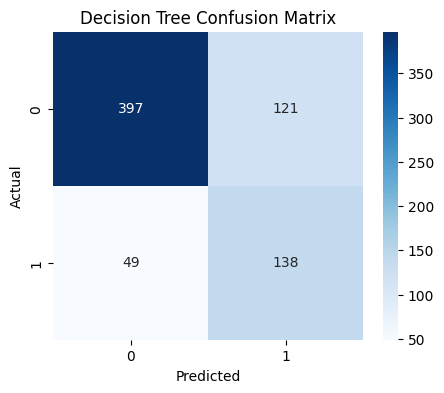

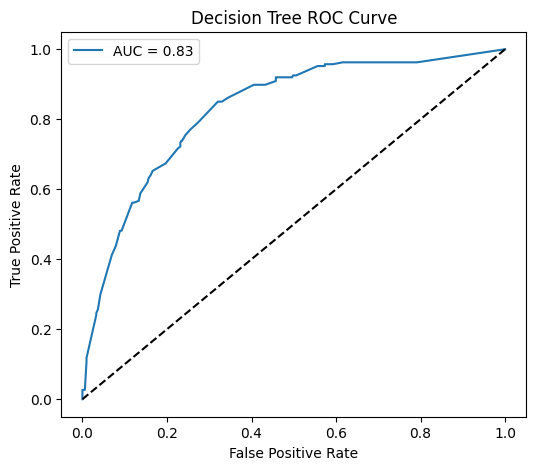

In [ ]:
# Decision Tree with Optuna and single validation split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
        class_weight=class_weight_dict
    )
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = accuracy_score(y_val, y_pred)
    print(f'Trial {trial.number}: max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}, score={score:.4f}')
    return score

study_dt = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_dt.optimize(objective_dt, n_trials=50)

print(f'\nBest Decision Tree Hyperparameters: {study_dt.best_params}')
print(f'Best Validation Accuracy: {study_dt.best_value:.4f}\n')

best_params_dt = study_dt.best_params
best_dt = DecisionTreeClassifier(**best_params_dt, random_state=SEED, class_weight=class_weight_dict)
best_dt.fit(X_train_proc, y_train)
y_test_pred_dt = best_dt.predict(X_test_proc)
y_test_proba_dt = best_dt.predict_proba(X_test_proc)[:, 1]

print('Decision Tree Test Metrics:')
print_metrics(y_test, y_test_pred_dt, pos_label='Yes')

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_dt)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba_dt, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_dt)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.show()


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 0: n_estimators=144, max_depth=10, learning_rate=0.222, score=0.7645


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 1: n_estimators=89, max_depth=2, learning_rate=0.261, score=0.7816


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 2: n_estimators=55, max_depth=10, learning_rate=0.251, score=0.7489


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 3: n_estimators=96, max_depth=4, learning_rate=0.162, score=0.7702


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 4: n_estimators=203, max_depth=3, learning_rate=0.095, score=0.7801


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 5: n_estimators=247, max_depth=3, learning_rate=0.159, score=0.7730


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 6: n_estimators=202, max_depth=3, learning_rate=0.029, score=0.7801


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 7: n_estimators=252, max_depth=4, learning_rate=0.038, score=0.7787


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 8: n_estimators=80, max_depth=6, learning_rate=0.020, score=0.7986


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 9: n_estimators=216, max_depth=4, learning_rate=0.161, score=0.7801


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 10: n_estimators=144, max_depth=7, learning_rate=0.084, score=0.7745


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 11: n_estimators=59, max_depth=7, learning_rate=0.293, score=0.7603


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 12: n_estimators=106, max_depth=8, learning_rate=0.210, score=0.7816


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 13: n_estimators=99, max_depth=2, learning_rate=0.101, score=0.7844


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 14: n_estimators=137, max_depth=6, learning_rate=0.088, score=0.7872


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 15: n_estimators=153, max_depth=6, learning_rate=0.062, score=0.7716


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 16: n_estimators=300, max_depth=6, learning_rate=0.017, score=0.7915


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 17: n_estimators=300, max_depth=5, learning_rate=0.012, score=0.7887


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 18: n_estimators=300, max_depth=8, learning_rate=0.130, score=0.7787


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 19: n_estimators=265, max_depth=8, learning_rate=0.053, score=0.7773


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 20: n_estimators=176, max_depth=5, learning_rate=0.012, score=0.7872


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 21: n_estimators=278, max_depth=5, learning_rate=0.011, score=0.7887


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 22: n_estimators=298, max_depth=5, learning_rate=0.060, score=0.7702


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 23: n_estimators=225, max_depth=7, learning_rate=0.036, score=0.7773


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 24: n_estimators=279, max_depth=6, learning_rate=0.121, score=0.7688


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 25: n_estimators=236, max_depth=5, learning_rate=0.067, score=0.7816


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 26: n_estimators=283, max_depth=6, learning_rate=0.013, score=0.7986


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 27: n_estimators=183, max_depth=9, learning_rate=0.028, score=0.7773


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 28: n_estimators=272, max_depth=6, learning_rate=0.189, score=0.7660


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 29: n_estimators=126, max_depth=7, learning_rate=0.046, score=0.7929


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 30: n_estimators=120, max_depth=7, learning_rate=0.044, score=0.7858


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 31: n_estimators=72, max_depth=6, learning_rate=0.025, score=0.7943


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 32: n_estimators=76, max_depth=7, learning_rate=0.076, score=0.7929


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 33: n_estimators=75, max_depth=9, learning_rate=0.046, score=0.7830


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 34: n_estimators=119, max_depth=6, learning_rate=0.109, score=0.7759


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 35: n_estimators=78, max_depth=8, learning_rate=0.030, score=0.7872


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 36: n_estimators=55, max_depth=7, learning_rate=0.070, score=0.7858


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 37: n_estimators=117, max_depth=9, learning_rate=0.052, score=0.7759


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 38: n_estimators=87, max_depth=4, learning_rate=0.141, score=0.7759


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 39: n_estimators=158, max_depth=6, learning_rate=0.025, score=0.7844


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 40: n_estimators=135, max_depth=10, learning_rate=0.040, score=0.7773


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 41: n_estimators=74, max_depth=7, learning_rate=0.078, score=0.7887


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 42: n_estimators=63, max_depth=7, learning_rate=0.026, score=0.7915


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 43: n_estimators=89, max_depth=8, learning_rate=0.075, score=0.7830


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 44: n_estimators=107, max_depth=6, learning_rate=0.051, score=0.7887


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:21:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 45: n_estimators=69, max_depth=7, learning_rate=0.179, score=0.7759


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 46: n_estimators=50, max_depth=5, learning_rate=0.232, score=0.7660


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 47: n_estimators=85, max_depth=6, learning_rate=0.089, score=0.7858


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 48: n_estimators=99, max_depth=7, learning_rate=0.024, score=0.7901


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Trial 49: n_estimators=194, max_depth=4, learning_rate=0.286, score=0.7603


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Metrics:
Accuracy: 0.7901 | Precision: 0.5907 | Recall: 0.6791 | Specificity: 0.8301 | F1: 0.6318


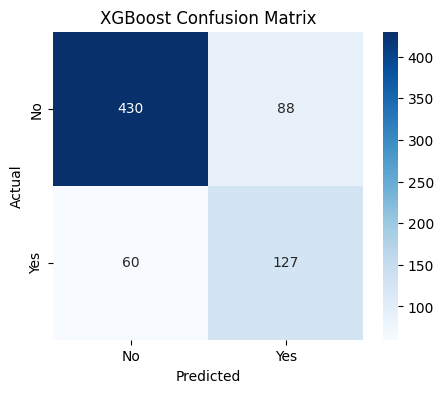

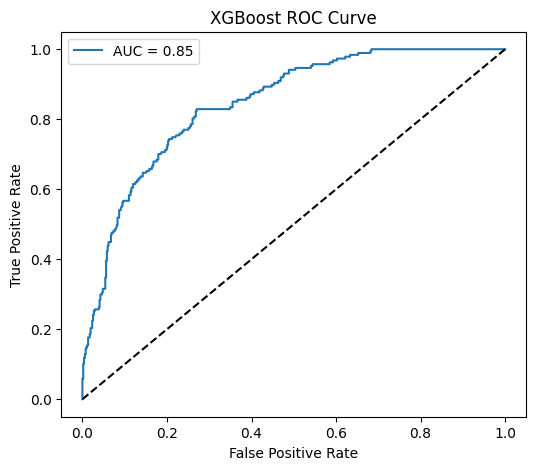

In [ ]:
# XGBoost, LightGBM, and KNN with Optuna, validation split, class weights, and plots
# Install required packages if not already installed
%pip install xgboost lightgbm

# Encode target for XGBoost and LightGBM
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

scale_pos_weight = class_weight_dict.get('Yes', 1) if 'Yes' in class_weight_dict else 1

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )
    clf.fit(X_train_proc, y_train_enc)
    y_pred = clf.predict(X_val_proc)
    score = accuracy_score(y_val_enc, y_pred)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate:.3f}, score={score:.4f}')
    return score

study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_xgb.optimize(objective_xgb, n_trials=50)

print(f'\nBest XGBoost Hyperparameters: {study_xgb.best_params}')
print(f'Best Validation Accuracy: {study_xgb.best_value:.4f}\n')

best_params_xgb = study_xgb.best_params
best_xgb = XGBClassifier(**best_params_xgb, random_state=SEED, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight)
best_xgb.fit(X_train_proc, y_train_enc)
y_test_pred_xgb = best_xgb.predict(X_test_proc)
y_test_proba_xgb = best_xgb.predict_proba(X_test_proc)[:, 1]

print('XGBoost Test Metrics:')
yes_label = le.transform(['Yes'])[0]
print_metrics(y_test_enc, y_test_pred_xgb, pos_label=yes_label)

cm = confusion_matrix(y_test_enc, y_test_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test_enc, y_test_proba_xgb, pos_label=yes_label)
auc = roc_auc_score(y_test_enc, y_test_proba_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend()
plt.show()



[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 10: n_estimators=289, max_depth=7, learning_rate=0.012, num_leaves=96, score=0.7702
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 11: n_estimators=292, max_depth=7, learning_rate=0.014, num_leaves=99, score=0.7660
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 13: n_estimators=227, max_depth=6, learning_rate=0.140, num_leaves=71, score=0.7603
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 14: n_estimators=241, max_depth=8, learning_rate=0.088, num_leaves=78, score=0.7674
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 18: n_estimators=172, max_depth=8, learning_rate=0.260, num_leaves=60, score=0.7518
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 19: n_estimators=265, max_depth=9, learning_rate=0.114, num_leaves=15, score=0.7617
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 20: n_estimators=232, max_depth=5, learning_rate=0.043, num_leaves=84, score=0.7546
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 21: n_estimators=287, max_depth=7, learning_rate=0.013, num_leaves=98, score=0.7645
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 22: n_estimators=277, max_depth=7, learning_rate=0.040, num_leaves=93, score=0.7617
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 31: n_estimators=275, max_depth=7, learning_rate=0.011, num_leaves=94, score=0.7688
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 36: n_estimators=183, max_depth=10, learning_rate=0.063, num_leaves=36, score=0.7433
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 39: n_estimators=195, max_depth=10, learning_rate=0.086, num_leaves=40, score=0.7589
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 40: n_estimators=158, max_depth=9, learning_rate=0.024, num_leaves=51, score=0.7688
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003232 seconds.
You c

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 41: n_estimators=254, max_depth=7, learning_rate=0.027, num_leaves=96, score=0.7631
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 42: n_estimators=287, max_depth=8, learning_rate=0.022, num_leaves=91, score=0.7631
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Trial 44: n_estimators=52, max_depth=8, learning_rate=0.035, num_leaves=86, score=0.7730
[LightGBM] [Info] Number of positive: 1495, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1145
[LightGBM] [Info] Number of data points in the train set: 5633, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/shreyasshah/Desktop/Fall_2025/STA 221/ecs221/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


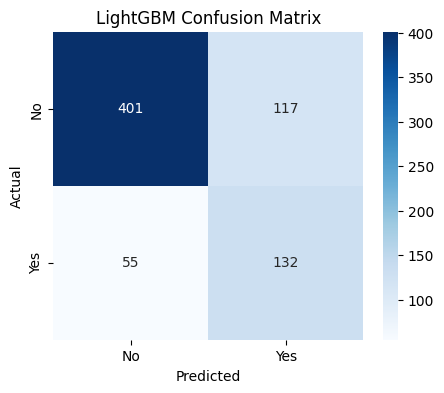

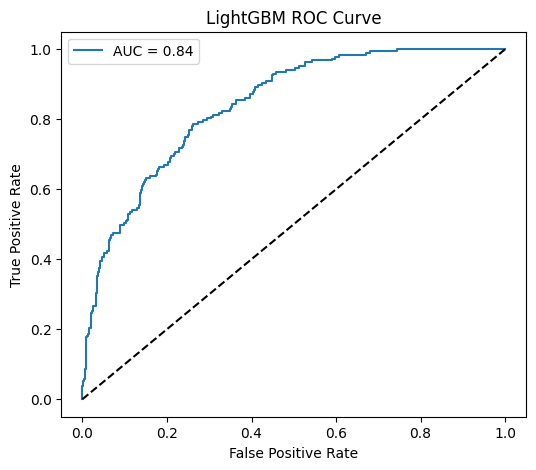

In [ ]:
# LightGBM (with encoded labels and encoded class weights)
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Use the same label encoder as XGBoost cell (already defined above)
# y_train_enc, y_val_enc, y_test_enc already exist

# Compute class weights for encoded labels
classes_enc = np.unique(y_train_enc)
class_weights_enc = compute_class_weight('balanced', classes=classes_enc, y=y_train_enc)
class_weight_dict_enc = dict(zip(classes_enc, class_weights_enc))

def objective_lgbm(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 10, 100)
    clf = LGBMClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        random_state=SEED,
        class_weight=class_weight_dict_enc
    )
    clf.fit(X_train_proc, y_train_enc)
    y_pred = clf.predict(X_val_proc)
    score = accuracy_score(y_val_enc, y_pred)
    print(f'Trial {trial.number}: n_estimators={n_estimators}, max_depth={max_depth}, learning_rate={learning_rate:.3f}, num_leaves={num_leaves}, score={score:.4f}')
    return score

study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_lgbm.optimize(objective_lgbm, n_trials=50)

print(f'\nBest LightGBM Hyperparameters: {study_lgbm.best_params}')
print(f'Best Validation Accuracy: {study_lgbm.best_value:.4f}\n')

best_params_lgbm = study_lgbm.best_params
best_lgbm = LGBMClassifier(**best_params_lgbm, random_state=SEED, class_weight=class_weight_dict_enc)
best_lgbm.fit(X_train_proc, y_train_enc)
y_test_pred_lgbm = best_lgbm.predict(X_test_proc)
y_test_proba_lgbm = best_lgbm.predict_proba(X_test_proc)[:, 1]

print('LightGBM Test Metrics:')
yes_label = le.transform(['Yes'])[0]
print_metrics(y_test_enc, y_test_pred_lgbm, pos_label=yes_label)

cm = confusion_matrix(y_test_enc, y_test_pred_lgbm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LightGBM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test_enc, y_test_proba_lgbm, pos_label=yes_label)
auc = roc_auc_score(y_test_enc, y_test_proba_lgbm)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend()
plt.show()

Trial 0: n_neighbors=13, weights=uniform, p=2, score=0.7872
Trial 1: n_neighbors=7, weights=uniform, p=2, score=0.7702
Trial 2: n_neighbors=19, weights=uniform, p=2, score=0.7816
Trial 3: n_neighbors=26, weights=uniform, p=1, score=0.7887
Trial 4: n_neighbors=11, weights=uniform, p=1, score=0.7773
Trial 5: n_neighbors=20, weights=distance, p=1, score=0.7801
Trial 6: n_neighbors=15, weights=uniform, p=2, score=0.7801
Trial 7: n_neighbors=19, weights=distance, p=1, score=0.7816
Trial 8: n_neighbors=4, weights=distance, p=2, score=0.7518
Trial 9: n_neighbors=11, weights=distance, p=1, score=0.7801
Trial 10: n_neighbors=29, weights=uniform, p=1, score=0.7872
Trial 11: n_neighbors=27, weights=uniform, p=2, score=0.7702
Trial 12: n_neighbors=24, weights=uniform, p=1, score=0.7929
Trial 13: n_neighbors=25, weights=uniform, p=1, score=0.7858
Trial 14: n_neighbors=23, weights=uniform, p=1, score=0.7887
Trial 15: n_neighbors=23, weights=uniform, p=1, score=0.7887
Trial 16: n_neighbors=28, weight

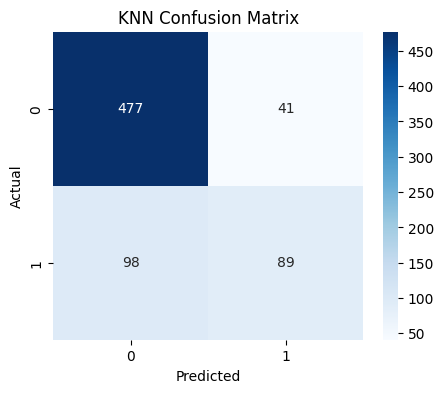

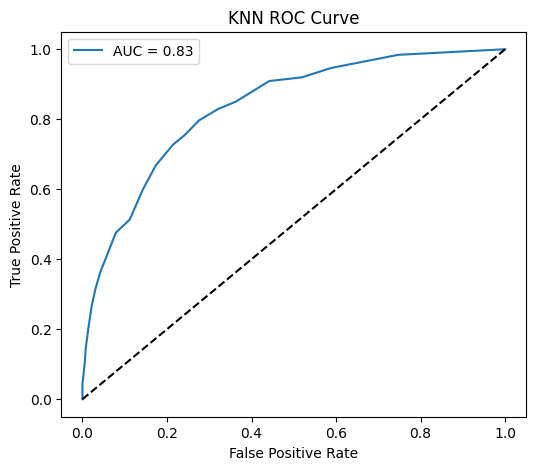

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_int('p', 1, 2)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    clf.fit(X_train_proc, y_train)
    y_pred = clf.predict(X_val_proc)
    score = accuracy_score(y_val, y_pred)
    print(f'Trial {trial.number}: n_neighbors={n_neighbors}, weights={weights}, p={p}, score={score:.4f}')
    return score

study_knn = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study_knn.optimize(objective_knn, n_trials=50)

print(f'\nBest KNN Hyperparameters: {study_knn.best_params}')
print(f'Best Validation Accuracy: {study_knn.best_value:.4f}\n')

best_params_knn = study_knn.best_params
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(X_train_proc, y_train)
y_test_pred_knn = best_knn.predict(X_test_proc)
# KNN does not have predict_proba for binary classification with non-probabilistic outputs, so use decision_function or fallback
try:
    y_test_proba_knn = best_knn.predict_proba(X_test_proc)[:, 1]
except AttributeError:
    y_test_proba_knn = (y_test_pred_knn == 'Yes').astype(int)

print('KNN Test Metrics:')
print_metrics(y_test, y_test_pred_knn, pos_label='Yes')

cm = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
fpr, tpr, _ = roc_curve(y_test, y_test_proba_knn, pos_label='Yes')
auc = roc_auc_score(y_test, y_test_proba_knn)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend()
plt.show()